In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#importing csv data to pandas dataframes
df_reviews = pd.read_csv('reviews.csv')
df_listings = pd.read_csv('listings.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43,61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,4826,3419,2009-06-01,13823,Anja,We just came back from a weeks stay at Kaan's ...
1,20815,31174,2010-03-24,49388,Chuck,My daughter and her friend and I all stayed at...
2,20815,40738,2010-05-08,93598,Sara,You cannot find a better place to stay in Turk...
3,20815,49182,2010-06-02,108540,Suzan,This comfortable apartment truly deserves the ...
4,20815,85462,2010-08-27,126482,William,I second all the excellent reviews of this pla...


In [5]:
df_listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,4826,https://www.airbnb.com/rooms/4826,20200428053711,2020-04-29,The Place,My place is close to great views. My place is ...,A double bed apartment on the Asian side of Is...,My place is close to great views. My place is ...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/15347/ba87...,NaN,6603,https://www.airbnb.com/users/show/6603,Kaan,2009-01-14,"Istanbul, Istanbul, Turkey","Hello...\r\nI am Kaan and I am from Istanbul, ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/6603/profile_...,https://a0.muscache.com/im/users/6603/profile_...,Üsküdar,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Istanbul Province, Istanbul, Turkey",Üsküdar,Uskudar,...,$182.00,1,730,1,1,730,730,1.0,730.0,36 months ago,t,30,60,90,365,2020-04-29,1,0,2009-06-01,2009-06-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,1,0,0,0.01
1,20815,https://www.airbnb.com/rooms/20815,20200428053711,2020-04-29,The Bosphorus from The Comfy Hill,Watch The Bosphorus from The Comfy Hill. A spa...,"The low green hills of Arnavutköy, the lovely,...",Watch The Bosphorus from The Comfy Hill. A spa...,none,"The lovely neighborhood, Arnavutkoy, is locate...",The house may be suited with extra inflatable ...,"The city center, Taksim is about 6-7 kilometer...",Our dear guests may enjoy the oven and the was...,"Depending on our time available, we may even t...",- Windows facing the street should not be left...,NaN,NaN,https://a0.muscache.com/im/pictures/94805791/4...,NaN,78838,https://www.airbnb.com/users/show/78838,Gülder,2010-02-08,"Ankara, Ankara, Turkey",Başar Family\r\n\r\nGülder (mother): Owner of ...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/78838/profile...,https://a0.muscache.com/im/users/78838/profile...,Beşiktaş,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'wor...",t,f,"Istanbul, Turkey",Beşiktaş,Besiktas,...,$245.00,365,900,365,365,900,900,365.0,900.0,5 months ago,t,12,23,36,241,2020-04-29,41,0,2010-03-24,2018-11-07,90.0,9.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,moderate,t,f,2,1,1,0,0.33


In [6]:
def clean_zipcode(input_series):

  output_list = [map_func_zipcode(item) for item in input_series]
  
  return pd.Series(output_list, index=input_series.index)


def map_func_zipcode(x):

  try:
    y = int(x)

    if y < 34000 or y > 35000:
      return str(0)

    return str(y)

  except:
    return str(0)


def clean_price(input_series):

  input_series = input_series.str.replace(',', '')
  input_series = input_series.str.replace('$', '')
  input_series = input_series.astype('float')

  return input_series

In [7]:
def clean_features(pd_series):

  if pd_series.name == 'zipcode':
    return clean_zipcode(pd_series)

  elif pd_series.name == 'price':
    return clean_price(pd_series)

  else:
    return pd_series 

In [8]:
df_listings = df_listings.apply(clean_features, axis=0)

In [9]:
df_reviews = df_reviews.drop(columns=['id', 'reviewer_id', 'reviewer_name'])

In [10]:
df_locations = df_listings[['id', 'neighbourhood_cleansed', 'zipcode', 'price']]

In [11]:
df_merged = df_locations.merge(df_reviews, left_on='id', right_on='listing_id', how='right' )
df_merged = df_merged.drop(columns=['listing_id'])

In [12]:
df_merged.head()

,id,neighbourhood_cleansed,zipcode,price,date,comments
0,4826,Uskudar,34684,734.0,2009-06-01,We just came back from a weeks stay at Kaan's ...
1,20815,Besiktas,34345,832.0,2010-03-24,My daughter and her friend and I all stayed at...
2,20815,Besiktas,34345,832.0,2010-05-08,You cannot find a better place to stay in Turk...
3,20815,Besiktas,34345,832.0,2010-06-02,This comfortable apartment truly deserves the ...
4,20815,Besiktas,34345,832.0,2010-08-27,I second all the excellent reviews of this pla...


In [13]:
df_merged.dtypes

id                          int64
neighbourhood_cleansed     object
zipcode                    object
price                     float64
date                       object
comments                   object
dtype: object

In [14]:
df_merged['date'] = pd.to_datetime(df_merged['date'], format='%Y/%m/%d')

In [15]:
df_merged.dtypes

id                                 int64
neighbourhood_cleansed            object
zipcode                           object
price                            float64
date                      datetime64[ns]
comments                          object
dtype: object

In [15]:
df_vis = df_merged.groupby('neighbourhood_cleansed').resample('M', on='date').count()

In [16]:
df_vis.head(10)

id  neighbourhood_cleansed  ...  date  comments
neighbourhood_cleansed date                                    ...                
Adalar                 2012-07-31   1                       1  ...     1         1
                       2012-08-31   0                       0  ...     0         0
                       2012-09-30   0                       0  ...     0         0
                       2012-10-31   0                       0  ...     0         0
                       2012-11-30   0                       0  ...     0         0
                       2012-12-31   0                       0  ...     0         0
                       2013-01-31   0                       0  ...     0         0
                       2013-02-28   0                       0  ...     0         0
                       2013-03-31   0                       0  ...     0         0
                       2013-04-30   0                       0  ...     0         0

[10 rows x 6 columns]

In [17]:
df_vis = df_vis.drop(columns=['date','neighbourhood_cleansed']).reset_index()

In [18]:
top_neighbourhood_list = df_merged.groupby('neighbourhood_cleansed').count().sort_values(by='comments', ascending=False)['comments'].index.to_list()[:7]

In [19]:
top_neighbourhood_list

['Beyoglu', 'Fatih', 'Sisli', 'Kadikoy', 'Besiktas', 'Uskudar', 'Adalar']

In [20]:
df_vis = df_vis[df_vis['neighbourhood_cleansed'].isin(top_neighbourhood_list)]

In [21]:
df_vis

,neighbourhood_cleansed,date,id,zipcode,price,comments
0,Adalar,2012-07-31,1,1,1,1
1,Adalar,2012-08-31,0,0,0,0
2,Adalar,2012-09-30,0,0,0,0
3,Adalar,2012-10-31,0,0,0,0
4,Adalar,2012-11-30,0,0,0,0
...,...,...,...,...,...,...
2765,Uskudar,2019-12-31,113,113,113,113
2766,Uskudar,2020-01-31,126,126,126,124
2767,Uskudar,2020-02-29,103,103,103,103
2768,Uskudar,2020-03-31,77,77,77,77


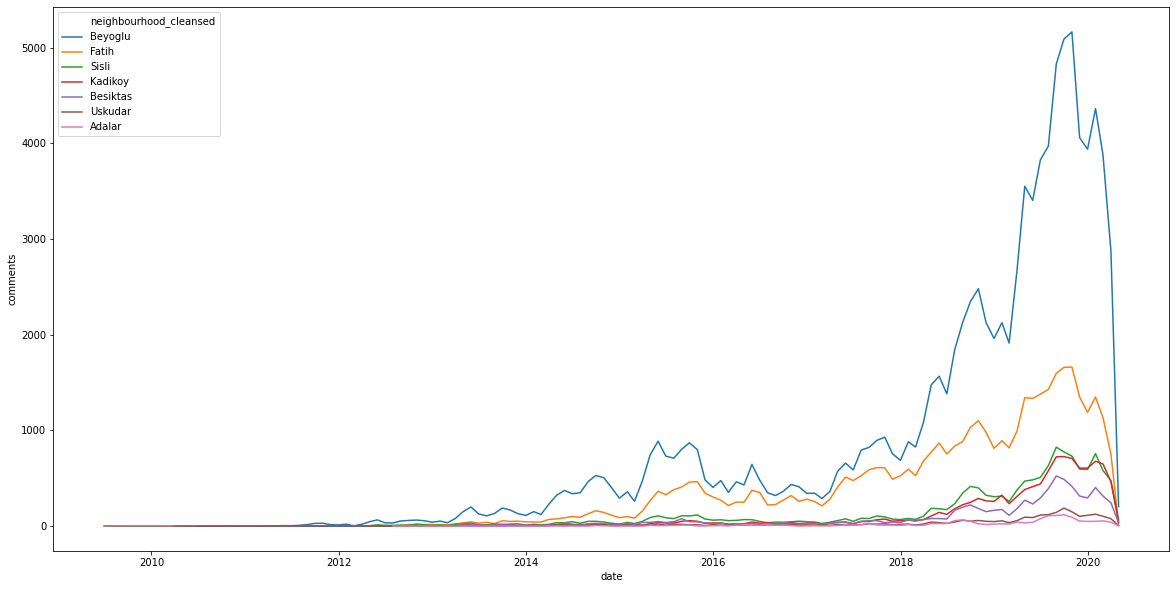

In [22]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_vis, x ='date' ,y='comments', hue='neighbourhood_cleansed', hue_order=top_neighbourhood_list)
             
plt.show()


Median prices for each neighbourhood

In [23]:
df_vis = df_merged.groupby('neighbourhood_cleansed').resample('6M', on='date').median()

In [24]:
df_vis = df_vis.reset_index()

In [25]:
df_vis = df_vis[df_vis['neighbourhood_cleansed'].isin(top_neighbourhood_list)]

In [26]:
df_prices = df_merged.groupby('neighbourhood_cleansed').median()
df_prices = df_prices.reset_index()
df_prices = df_prices.sort_values(by='price', ascending=False)

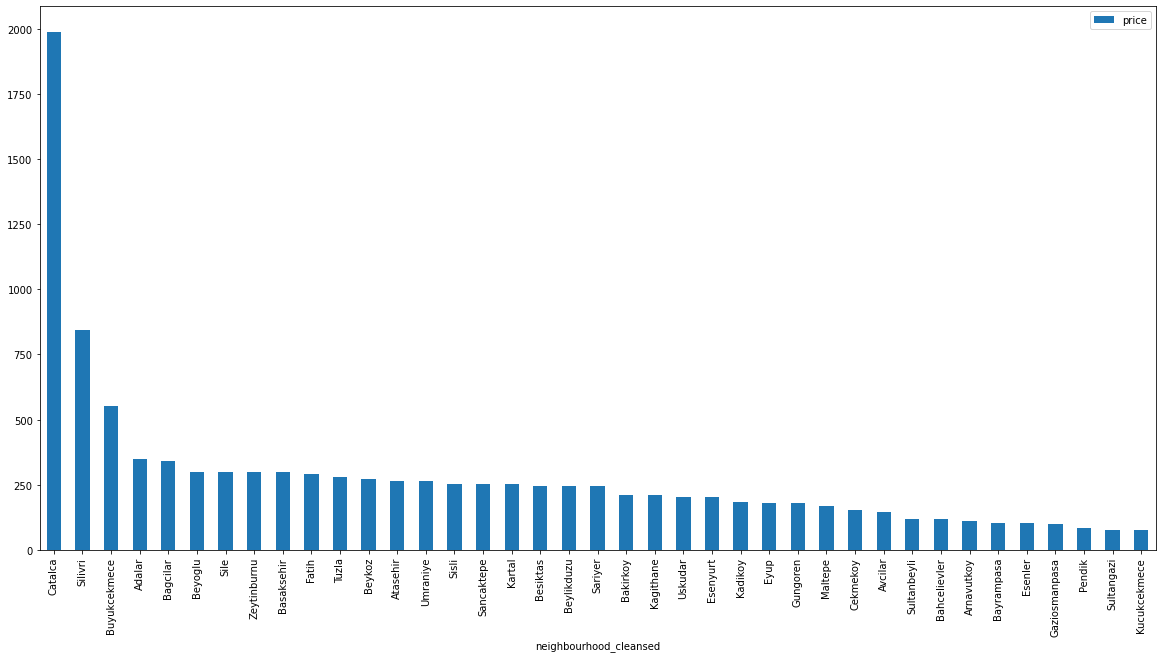

In [27]:
df_prices.plot.bar(x='neighbourhood_cleansed', y='price', rot=90, figsize=(20,10))

In [28]:
df_merged['neighbourhood_cleansed'].value_counts()

Beyoglu          102543
Fatih             42875
Sisli             14342
Kadikoy           11384
Besiktas           7793
Uskudar            2682
Adalar             1551
Atasehir           1469
Pendik             1126
Maltepe            1034
Bakirkoy            987
Kagithane           862
Esenyurt            808
Sariyer             755
Sile                652
Bahcelievler        635
Eyup                531
Arnavutkoy          373
Umraniye            364
Basaksehir          346
Gaziosmanpasa       341
Avcilar             284
Kartal              255
Zeytinburnu         251
Kucukcekmece        250
Bagcilar            217
Beykoz              216
Gungoren            179
Tuzla               140
Buyukcekmece        137
Beylikduzu          107
Cekmekoy             77
Sultanbeyli          51
Bayrampasa           49
Sancaktepe           36
Silivri              30
Sultangazi           23
Esenler              16
Catalca               9
Name: neighbourhood_cleansed, dtype: int64

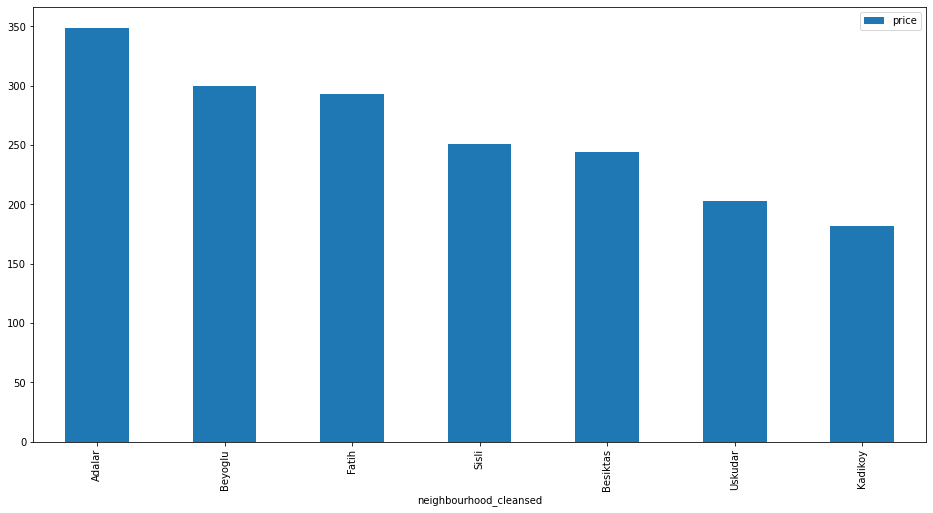

In [34]:
df_prices_top_neighbourhoods = df_prices[df_prices['neighbourhood_cleansed'].isin(top_neighbourhood_list)]
df_prices_top_neighbourhoods.plot.bar(x='neighbourhood_cleansed', y='price', rot=90, figsize=(16,8));

Visualizing smaller neighbourhoods using zipcodes

In [108]:
df_vis_zip = df_merged.groupby('zipcode').resample('3M', on='date').count()
df_vis_zip = df_vis_zip.drop(columns=['date','zipcode']).reset_index()
top_neighbourhood_list = df_merged.groupby('zipcode').count().sort_values(by='comments', ascending=False)['comments'].index.to_list()[:7]
df_vis_zip = df_vis_zip[df_vis_zip['zipcode'].isin(top_neighbourhood_list)]

In [109]:
top_neighbourhood_list

['34435', '34122', '34200', '0', '34433', '34421', '34425']

In [110]:
top_neighbourhood_list.remove('0')

In [111]:
zip_neighbourhood_dict = {'34435': 'Tarlabasi', '34122': 'Sultanahmet', '34200': 'Bagcilar',
                          '34433': 'Cihangir', '34421': 'Arapcami', '34425': 'Kemankes'}

In [112]:
top_neighbourhood_names = list(zip_neighbourhood_dict.values())

In [113]:
df_vis_zip['neighbourhood_zipcode'] = df_vis_zip['zipcode'].map(zip_neighbourhood_dict)
df_vis_zip = df_vis_zip.drop(columns=['zipcode'])

In [114]:
df_vis_zip = df_vis_zip[df_vis_zip['neighbourhood_zipcode'].isin(top_neighbourhood_names)]

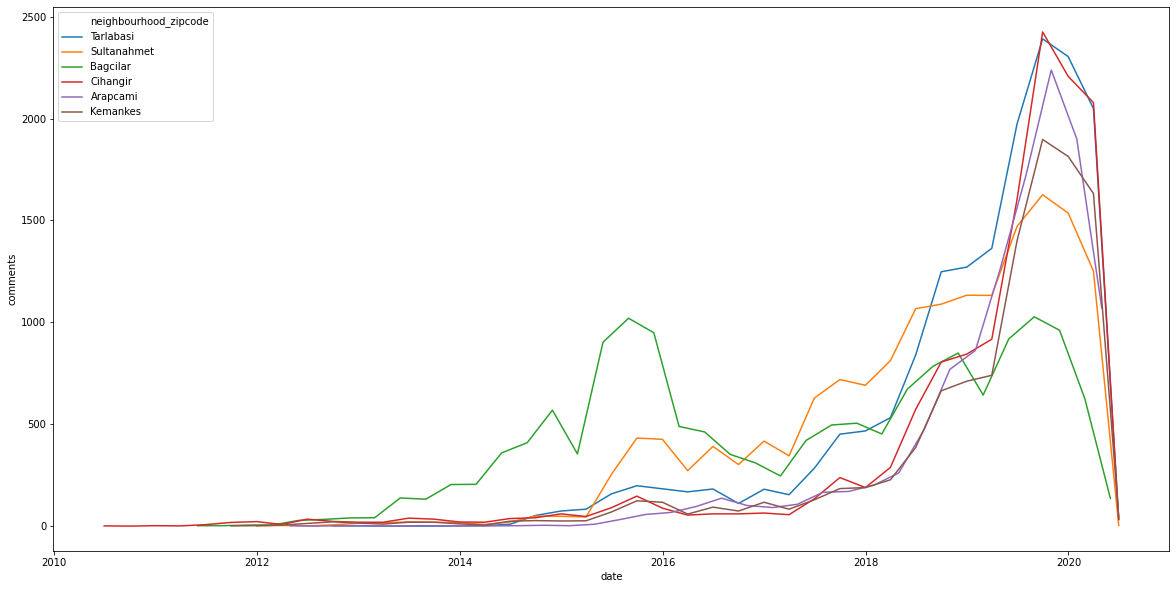

In [115]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_vis_zip, x ='date', y='comments', hue='neighbourhood_zipcode', hue_order=top_neighbourhood_names)
             
plt.show()


In [120]:
map3 = folium.Map(location=[38.9, -77.05], tiles='CartoDB positron', zoom_start=11)

marker_cluster = folium.MarkerCluster().add_to(map3)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup='ID:'+df_counters['ID'][point]+' '+df_counters['Name'][point], icon=folium.Icon(color=df_counters["color"][point], icon_color='white', icon='male', angle=0, prefix='fa')).add_to(marker_cluster)
map3

AttributeError: ignored

In [131]:
df_merged['neighbourhood_cleansed'].value_counts().reset_index()

,index,neighbourhood_cleansed
0,Beyoglu,102543
1,Fatih,42875
2,Sisli,14342
3,Kadikoy,11384
4,Besiktas,7793
5,Uskudar,2682
6,Adalar,1551
7,Atasehir,1469
8,Pendik,1126
9,Maltepe,1034


In [ ]:
pandas.merge(left, right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

In [159]:
import folium
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [126]:
gpd_neighbourhoods = gpd.read_file('neighbourhoods.geojson')

In [141]:
gpd_neighbourhoods.head()

,neighbourhood,neighbourhood_group,geometry,index,neighbourhood_cleansed
0,Sile,None,"MULTIPOLYGON (((29.40004 41.08274, 29.40101 41...",Sile,652
1,Catalca,None,"MULTIPOLYGON (((28.53614 41.10624, 28.53185 41...",Catalca,9
2,Eyup,None,"MULTIPOLYGON (((28.94881 41.26322, 28.94760 41...",Eyup,531
3,Sariyer,None,"MULTIPOLYGON (((29.05429 41.08144, 29.05436 41...",Sariyer,755
4,Arnavutkoy,None,"MULTIPOLYGON (((28.81849 41.13628, 28.80986 41...",Arnavutkoy,373


In [134]:
gpd_neighbourhoods = pd.merge(gpd_neighbourhoods, df_merged['neighbourhood_cleansed'].value_counts().reset_index(), left_on='neighbourhood', right_on='index')

In [160]:
istanbul = [41.0082, 28.9784]

# Create map
m = folium.Map(location=istanbul, tiles='Mapbox Control Room', zoom_start=11, width='60%', height='60%')



# Build choropleth
m.choropleth(
    geo_data=gpd_neighbourhoods,
    name='geometry',
    data=gpd_neighbourhoods,
    columns=['neighbourhood', 'neighbourhood_cleansed'],
    key_on='feature.properties.neighbourhood',
    fill_color='Reds',
    fill_opacity=0.5,
    line_opacity=1.0,
    legend_name='Number of comments for each neighbourhood'
)


# Create LayerControl and add it to the map            
folium.LayerControl().add_to(m)

# Display the map
display(m)  

In [82]:
df_bar = df_vis_zip.groupby('neighbourhood_zipcode')['comments'].sum().sort_values(ascending=False)
df_bar = df_bar.drop(labels=['missing'])

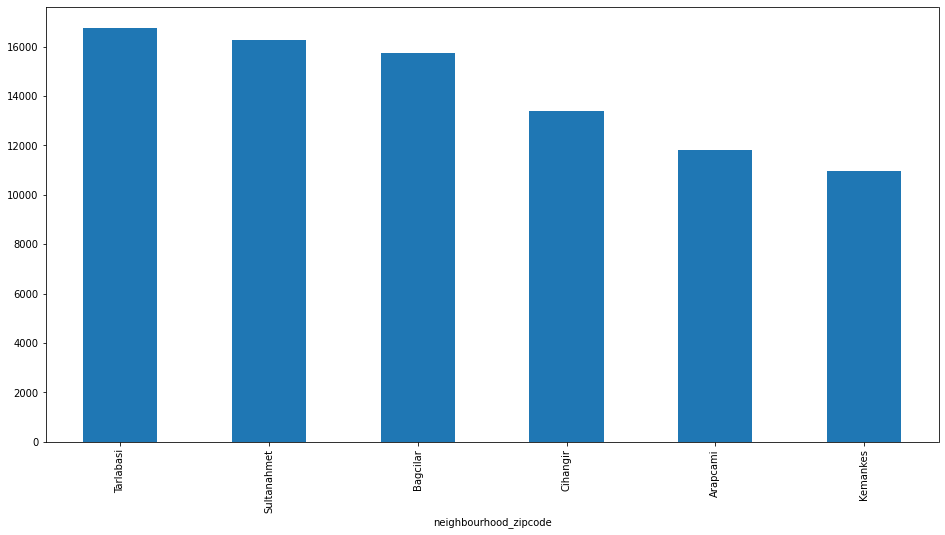

In [83]:
df_bar.plot.bar(x='neighbourhood_zipcode', y='comments', rot=90, figsize=(16,8));

In [84]:
df_bar = df_vis_zip.groupby('neighbourhood_zipcode')['price'].median().sort_values(ascending=False)
df_bar = df_bar.drop(labels=['missing'])

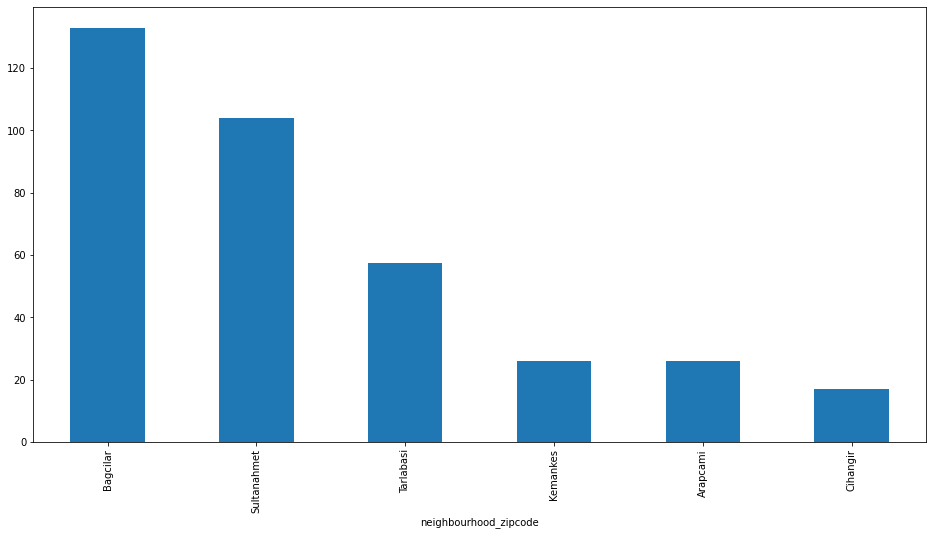

In [85]:
df_bar.plot.bar(x='neighbourhood_zipcode', y='comments', rot=90, figsize=(16,8));

Word Clouds

In [ ]:
df_reviews['comments'].head()

0    We just came back from a weeks stay at Kaan's ...
1    My daughter and her friend and I all stayed at...
2    You cannot find a better place to stay in Turk...
3    This comfortable apartment truly deserves the ...
4    I second all the excellent reviews of this pla...
Name: comments, dtype: object

In [ ]:
all_text = str()

for index, row in df_reviews.iterrows():

  if isinstance(row['comments'], str):
    all_text += row['comments']

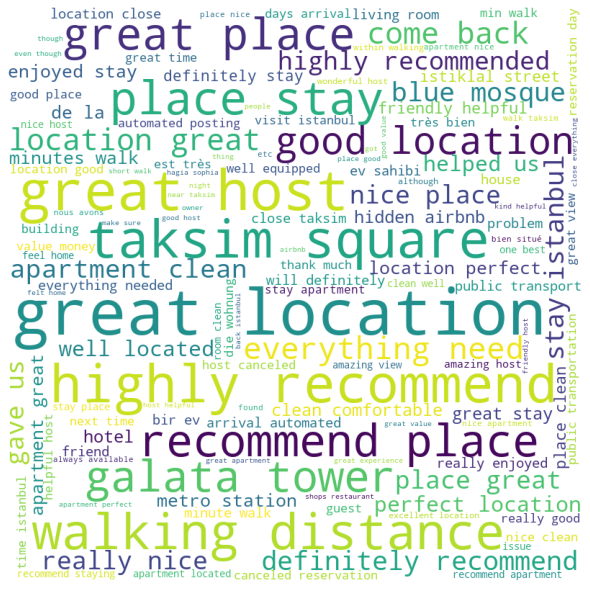

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
# Reading csv file to a data frame 
df = pd.read_csv('reviews.csv') 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.comments: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
! pip install pgeocode

In [ ]:
import pgeocode

In [ ]:
nomi = pgeocode.Nominatim('fr')
nomi.query_postal_code("75013")

HTTPError: ignored